In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/dataset_cleaned.csv


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
import string

In [3]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['label']

        # Calculate additional features
        verb_count, punctuation_percentage = calculate_features(text)
        ner_count = calculate_ner(text)

        # Tokenize text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': torch.tensor(label),
            'verb_count': torch.tensor(verb_count),
            'punctuation_percentage': torch.tensor(punctuation_percentage),
            'ner_count': torch.tensor(ner_count)
        }


Using device: cuda


In [4]:

# Function to calculate verb count and punctuation percentage for a given text
def calculate_features(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Tag the tokens with their parts of speech
    tagged_tokens = pos_tag(tokens)

    # Calculate the verb count
    verb_count = sum(1 for _, tag in tagged_tokens if tag.startswith('VB'))

    # Calculate the punctuation percentage
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    total_characters = len(text)
    punctuation_percentage = punctuation_count / total_characters * 100

    return verb_count, punctuation_percentage

# Function to calculate NER count for a given text
def calculate_ner(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Perform Named Entity Recognition
    chunked_tokens = ne_chunk(pos_tag(tokens))

    # Count the number of Named Entities
    ner_count = sum(1 for chunk in chunked_tokens if hasattr(chunk, 'label'))

    return ner_count


In [5]:
df = pd.read_csv("/kaggle/input/dataset/dataset_cleaned.csv")

In [6]:
# Select 50 samples from each class
sub_df = df.groupby('label').apply(lambda x: x.sample(n=50)).reset_index(drop=True)

# Display the information about the sub dataset
print("# Sub Dataset: {:,}".format(len(sub_df)))
print("# Sample:")
display(sub_df.head())

# Sub Dataset: 100
# Sample:


/tmp/ipykernel_399/2424748828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_df = df.groupby('label').apply(lambda x: x.sample(n=50)).reset_index(drop=True)


,text,label
0,If weather or not students should or should no...,0
1,The author supports the idea of studying Venus...,0
2,the electoral college is pretty bad. you shoul...,0
3,"First off, I would like to tell you that we ha...",0
4,"""\n\nyour principal has decided that all stude...",0


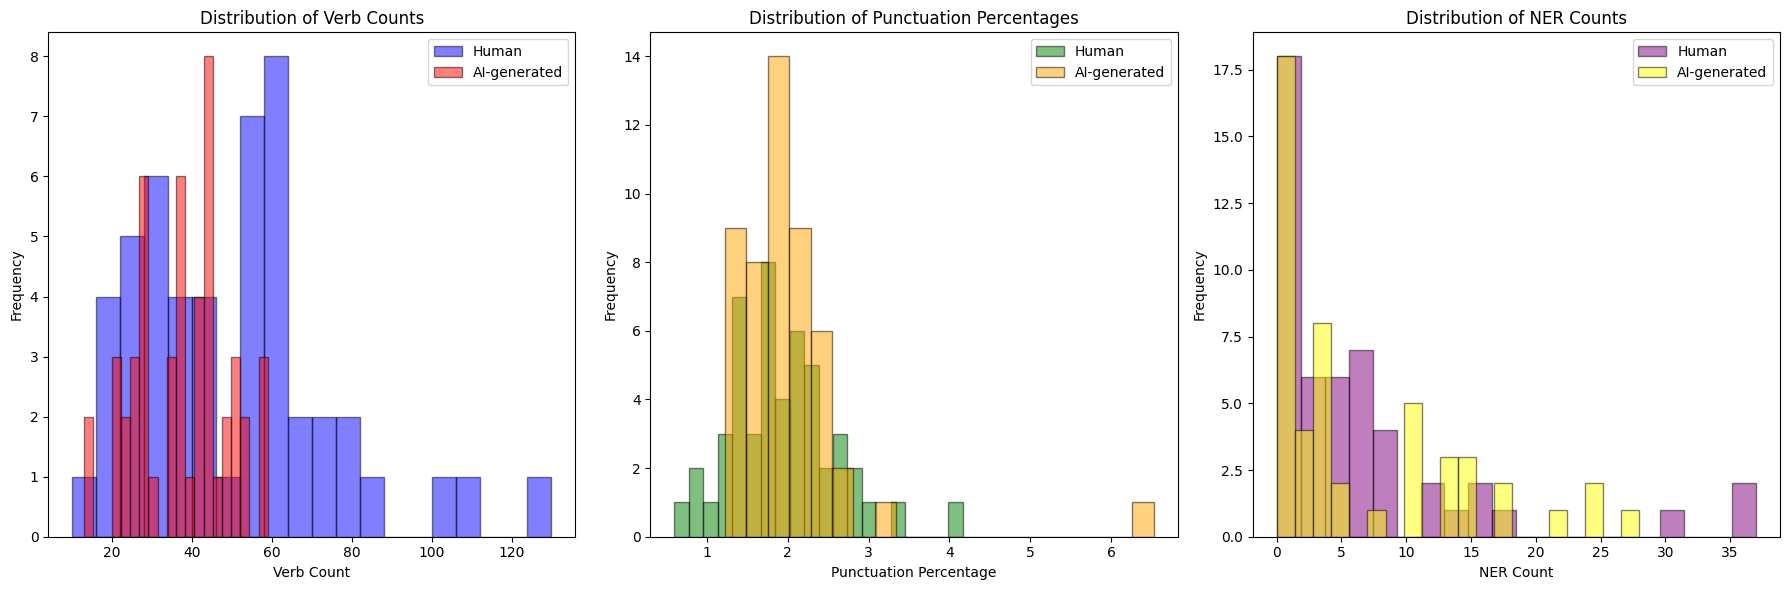

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to visualize the dataset features with differentiation based on labels
def visualize_features_with_labels(dataframe):
    human_texts = dataframe[sub_df['label'] == 0]['text']
    ai_texts = dataframe[sub_df['label'] == 1]['text']

    human_verb_counts = []
    human_punctuation_percentages = []
    human_ner_counts = []

    ai_verb_counts = []
    ai_punctuation_percentages = []
    ai_ner_counts = []

    # Calculate additional features for human texts
    for text in human_texts:
        verb_count, punctuation_percentage = calculate_features(text)
        ner_count = calculate_ner(text)

        human_verb_counts.append(verb_count)
        human_punctuation_percentages.append(punctuation_percentage)
        human_ner_counts.append(ner_count)

    # Calculate additional features for AI-generated texts
    for text in ai_texts:
        verb_count, punctuation_percentage = calculate_features(text)
        ner_count = calculate_ner(text)

        ai_verb_counts.append(verb_count)
        ai_punctuation_percentages.append(punctuation_percentage)
        ai_ner_counts.append(ner_count)

    # Visualize the features
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.hist(human_verb_counts, bins=20, color='blue', edgecolor='black', alpha=0.5, label='Human')
    plt.hist(ai_verb_counts, bins=20, color='red', edgecolor='black', alpha=0.5, label='AI-generated')
    plt.xlabel('Verb Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of Verb Counts')

    plt.subplot(1, 3, 2)
    plt.hist(human_punctuation_percentages, bins=20, color='green', edgecolor='black', alpha=0.5, label='Human')
    plt.hist(ai_punctuation_percentages, bins=20, color='orange', edgecolor='black', alpha=0.5, label='AI-generated')
    plt.xlabel('Punctuation Percentage')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of Punctuation Percentages')

    plt.subplot(1, 3, 3)
    plt.hist(human_ner_counts, bins=20, color='purple', edgecolor='black', alpha=0.5, label='Human')
    plt.hist(ai_ner_counts, bins=20, color='yellow', edgecolor='black', alpha=0.5, label='AI-generated')
    plt.xlabel('NER Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of NER Counts')

    plt.tight_layout()
    plt.show()


# Visualize features with differentiation based on labels
visualize_features_with_labels(sub_df)


In [7]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(sub_df, test_size=0.2, random_state=42)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:

# Define max sequence length
max_length = 512


In [10]:
# Create the custom datasets
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)



In [11]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Define BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:

# Define loss function
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Define number of epochs
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} (Train)"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        verb_count = batch['verb_count'].to(device)
        punctuation_percentage = batch['punctuation_percentage'].to(device)
        ner_count = batch['ner_count'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Average Loss for Epoch {epoch + 1} (Train): {avg_train_loss}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} (Val)"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            verb_count = batch['verb_count'].to(device)
            punctuation_percentage = batch['punctuation_percentage'].to(device)
            ner_count = batch['ner_count'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Average Loss for Epoch {epoch + 1} (Val): {avg_val_loss}")
    print(f"Validation Accuracy for Epoch {epoch + 1}: {val_accuracy * 100}%")

    # Adjust learning rate
    scheduler.step()

Epoch 1 (Train): 100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


Average Loss for Epoch 1 (Train): 0.7254281044006348


Epoch 1 (Val): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


Average Loss for Epoch 1 (Val): 0.63288614153862
Validation Accuracy for Epoch 1: 65.0%


Epoch 2 (Train): 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


Average Loss for Epoch 2 (Train): 0.614837384223938


Epoch 2 (Val): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Average Loss for Epoch 2 (Val): 0.4971051961183548
Validation Accuracy for Epoch 2: 100.0%


Epoch 3 (Train): 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Average Loss for Epoch 3 (Train): 0.4718880355358124


Epoch 3 (Val): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

Average Loss for Epoch 3 (Val): 0.3674123138189316
Validation Accuracy for Epoch 3: 95.0%


In [16]:
def predict_text_origin(texts, tokenizer, model, device):
    model.eval()
    predictions = []
    
    for text in texts:
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        predictions.append(predicted_class)
    
    return predictions


In [19]:
def predict_text_origin(text, tokenizer, model, device):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    # Forward pass through the model
    outputs = model(**inputs)

    # Get predicted probabilities and labels
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)

    return predicted_labels


In [23]:
texts_to_predict = ''' The main work here is significant software engineering to bring the code up to
product-caliber: This code will be deployed to users and thus needs to follow precise specifications, have comprehensive
test coverage, well-defined APIs, etc. The resulting ML modules should be robustified towards one or more target
use-cases. If those target use-cases call for model explanations, the methods need to be built and validated alongside
the ML model, and tested for their efficacy in faithfully interpreting the model’s decisions – crucially, this needs to be
in the context of downstream tasks and the end-users, as there is often a gap between ML explainability that serves
ML engineers rather than external stakeholders'''

predicted_labels = predict_text_origin(texts_to_predict, tokenizer, model, device)

print(f"Predicted Label: {'AI-generated' if predicted_labels == 1 else 'Human-written'}\n")

Predicted Label: AI-generated



In [24]:
texts_to_predict = ''' Once, I decided to visit Rameshwaram, along with a group of friends. When Kalam got to know, he
was very eager to go with us as it is his birth place. He said he would join us in Madurai railway
station. He had made all the arrangements when his nomination for the post of President of India was
announced. He told me, ‘We will keep the plan open for Rameshwaram.'''

predicted_labels = predict_text_origin(texts_to_predict, tokenizer, model, device)

print(f"Predicted Label: {'AI-generated' if predicted_labels == 1 else 'Human-written'}\n")

Predicted Label: Human-written

